# The Laplace approximation

### Load packages

In [1]:
from numpy.polynomial.hermite import hermgauss
from matplotlib import pyplot as plt
from numpy.linalg import inv
import pandas as pd
import numpy as np
import scipy
import time
from scipy.stats import norm

### Randomized simulation data for two sites
- Set random seed
- Generate 10 true betas ranged in (-10, 10)
- Generate 2 sigmas for noise variance in different sites
- Generate data X1 and X2 with size (1000, 10)
- Generate result y1 and y2 with bernoulli distibution 

In [2]:
np.random.seed(30)
true_beta = (np.random.rand(10,1) - np.random.rand(10,1)) * 10
true_sigma = np.random.rand(2)
X1 = (np.random.rand(1000, 10) - np.random.rand(1000, 10)) * 10
p1 = 1 / (1 + np.exp(-(X1 @ true_beta + np.random.normal(0, true_sigma[0], 1000).reshape(1000, 1))))
y1 = np.random.binomial(1,p1)
X2 = (np.random.rand(1000, 10) - np.random.rand(1000, 10)) * 10
p2 = 1 / (1 + np.exp(-(X2 @ true_beta + np.random.normal(0, true_sigma[1], 1000).reshape(1000, 1))))
y2 = np.random.binomial(1,p2)

### Definitions

Notation for $\pi_{ij}$:

$$\pi_{ij} = \dfrac{\exp{(X_{ij}^\top\beta_0}+\mu_{i0})}{1 + \exp{(X_{ij}^\top\beta_0}+\mu_{i0})}$$

In [3]:
def Pi(x, beta_0, mu):
    result = np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu))))
    if np.exp(x @ beta_0 + mu).max() == np.inf:
        return np.nan_to_num(result, nan = 1)
    else:
        return result

Notation for $g(\mu_{i0})$:

$$g(\mu_{i0};\beta_0)=\sum_{j=1}^{n_i}\left[y_{ij}\log\pi_{ij}+(1-y_{ij})\log(1-\pi_{ij})\right]+\log\phi(\mu_{i};\tau_{i})$$

In [4]:
def g(x, y, mu, beta_0, tau=1):
    g = sum(y * np.log(Pi(x, beta_0, mu)) + (1 - y) * np.log(1 - Pi(x, beta_0, mu))) \
    + np.log((np.sqrt(2 * np.pi) * tau)**(-1) * np.exp(-mu**2/(2 * tau**2)))
    return g

In [5]:
# Plugged in log-sum-exp trick
def logsumexp(x):
    c = x.max()
    LSE = c + np.log(np.sum(np.exp(x - c)))
    return np.exp(x - LSE)

def g(x, y, mu, beta_0, tau=1):
    g = sum(y * logsumexp(Pi(x, beta_0, mu)) + (1 - y) * logsumexp(1 - Pi(x, beta_0, mu))) \
    + np.log((np.sqrt(2 * np.pi) * tau)**(-1) * np.exp(-mu**2/(2 * tau**2)))
    return g

Notation for $g_\beta(\mu_{i0})$:

$$\dfrac{\partial g}{\partial \beta_0}=\sum_{j=1}^{n_i}(X_{ij}y_{ij}-X_{ij}\pi_{ij})$$

In [6]:
def g_b(x, y, mu, beta_0, tau = 1):
    return np.sum(x * y - x * Pi(x, beta_0, mu), axis = 0)

Notation for $g_\mu(\mu_{i0})$:

$$\dfrac{\partial g}{\partial \mu_{i0}}=\sum_{j=1}^{n_i}(y_{ij}-\pi_{ij})-\dfrac{\mu_{i0}}{\tau_0^2}$$

In [7]:
def g_u(x, y, mu, beta_0, tau = 1):
    return sum(y - Pi(x, beta_0, mu)) - mu/tau**2

Notation for $g_{\mu\mu}(\mu_{i0})$:

$$\dfrac{\partial^2 g}{\partial \mu_{i0}^2}=-\sum_{j=1}^{n_i}\dfrac{\partial\pi_{ij}}{\partial\mu_{i0}}-\dfrac{1}{\tau_0^2}$$

In [8]:
def g_uu(x, y, mu, beta_0, tau = 1):
    result = np.nan_to_num(- np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu))**2)), nan = 0)
    return sum(result) - 1/tau**2

Notation for $g_{\mu\beta}(\mu_{i0})$:

$$\dfrac{\partial^2 g}{\partial \mu_{i0}\partial \beta_0}=-\sum_{j=1}^{n_i}\dfrac{\partial\pi_{ij}}{\partial\beta_0}$$

In [9]:
def g_ub(x, y, mu, beta_0, tau = 1):
    result = np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu))**2)), nan = 0)
    return np.sum(- x * result, axis = 0)

Notation for $g_{\beta\beta}(\mu_{i0})$:

$$\dfrac{\partial^2 g}{\partial \beta_0^2}=-\sum_{j=1}^{n_i}X_{ij}\dfrac{\partial\pi_{ij}}{\partial\beta_0}$$

In [10]:
def g_bb(x, y, mu, beta_0, tau = 1):
    result = 0
    for i in range(len(y)):
        result += -np.asarray(x[i].reshape(x.shape[1],1) @ x[i].reshape(1,x.shape[1])\
        * np.nan_to_num((np.exp(x[i] @ beta_0 + mu) / (1 + np.exp(x[i] @ beta_0 + mu))**2), nan = 0))
    return result

Notation for $g_{\mu\beta}(\hat\mu_{i0};\beta_0)$:

$$\dfrac{\partial g_u(\hat\mu(\beta_0);\beta_0)}{\partial \beta_0}=\hat\mu_\beta(\beta_0)g_{\mu\mu}(\hat\mu_{i0})+g_{\mu\beta}(\hat\mu_{i0})=0$$

Notation for $g_{\mu\mu\mu}(\hat\mu_{i0};\beta_0)$:

$$g_{\mu\mu\mu}(\hat\mu_{i0};\beta_0) = -\sum_{j=1}^{n_i}\dfrac{\partial^2\pi_{ij}}{\partial\mu_{i0}^2}$$

In [11]:
def g_uuu(x, y, mu, beta_0, tau = 1):
    return sum(- np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**3)), nan = 0))

Notation for $g_{\mu\mu\beta}(\hat\mu_{i0};\beta_0)$:

$$g_{\mu\mu\beta}(\hat\mu_{i0};\beta_0) = -\sum_{j=1}^{n_i}\dfrac{\partial^2\pi_{ij}}{\partial\mu_{i0}\partial\beta_0}$$

In [12]:
def g_uub(x, y, mu, beta_0, tau = 1):
    return np.sum(- x * np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**3)), nan = 0), axis = 0)

Notation for $g_{\mu\beta\beta}(\hat\mu_{i0};\beta_0)$:

$$\dfrac{\partial^3 g}{\partial \mu_{i0}\partial \beta_0^2}=-\sum_{j=1}^{n_i}\dfrac{\partial^2\pi_{ij}}{\partial\beta_0^2}$$

In [13]:
def g_ubb(x, y, mu, beta_0, tau = 1):
    result = 0
    for i in range(len(y)):
        result += -np.asarray(x[i].reshape(x.shape[1],1) @ x[i].reshape(1,x.shape[1])\
                         * np.nan_to_num((np.exp(x[i] @ beta_0 + mu) * (np.exp(x[i] @ beta_0 + mu) - 1)\
                                       / (1 + np.exp(x[i] @ beta_0 + mu))**3), nan = 0))
    return result

Notation for $g_{\mu\mu\mu\mu}(\hat\mu_{i0};\beta_0)$:

$$g_{\mu\mu\mu\mu}(\hat\mu_{i0};\beta_0) = -\sum_{j=1}^{n_i}\dfrac{\partial^3\pi_{ij}}{\partial\mu_{i0}^3}$$

In [14]:
def g_uuuu(x, y, mu, beta_0, tau = 1):
    result = sum(- np.nan_to_num((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**3), nan = 0)\
                 + np.nan_to_num((3 * np.exp(2 * (x @ beta_0 + mu)) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**4), nan = 0)\
                 - np.nan_to_num((np.exp(2 * (x @ beta_0 + mu))  / (1 + np.exp(x @ beta_0 + mu))**3), nan = 0)\
                )
    return result

Notation for $g_{\mu\mu\mu\beta}(\hat\mu_{i0};\beta_0)$:

$$g_{\mu\mu\mu\beta}(\hat\mu_{i0};\beta_0) = -\sum_{j=1}^{n_i}\dfrac{\partial^3\pi_{ij}}{\partial\mu_{i0}^2\partial\beta_0}$$

In [15]:
def g_uuub(x, y, mu, beta_0, tau = 1):
    result = np.sum(- x * np.asarray(np.nan_to_num((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**3), nan = 0)\
                 + np.nan_to_num((3 * np.exp(2 * (x @ beta_0 + mu)) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**4), nan = 0)\
                 - np.nan_to_num((np.exp(2 * (x @ beta_0 + mu))  / (1 + np.exp(x @ beta_0 + mu))**3), nan = 0))
                    , axis = 0)
    return result

Notation for $g_{\mu\mu\beta\beta}(\hat\mu_{i0};\beta_0)$:

$$g_{\mu\mu\beta\beta}(\hat\mu_{i0};\beta_0) = -\sum_{j=1}^{n_i}\dfrac{\partial^3\pi_{ij}}{\partial\mu_{i0}\partial\beta^2_0}$$

In [16]:
def g_uubb(x, y, mu, beta_0, tau = 1):
    result = 0
    for i in range(len(y)):
        result += -np.asarray(x[i].reshape(x.shape[1],1) @ x[i].reshape(1,x.shape[1])\
                             * (np.nan_to_num((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**3), nan = 0)\
                 + np.nan_to_num((3 * np.exp(2 * (x @ beta_0 + mu)) * (np.exp(x @ beta_0 + mu) - 1)\
                             / (1 + np.exp(x @ beta_0 + mu))**4), nan = 0)\
                 - np.nan_to_num((np.exp(2 * (x @ beta_0 + mu))  / (1 + np.exp(x @ beta_0 + mu))**3), nan = 0)))
        
    return result

Notation for $\hat\omega$:

$$\hat\omega=\sqrt{-\dfrac{1}{g_{\mu\mu}(\hat\mu_{i0})}}$$

In [17]:
def omega(x, y, mu, beta_0, tau = 1):
    return np.sqrt(-1/g_uu(x, y, mu, beta_0))

Notation for $\hat\omega_\beta$:

$$\dfrac{\partial\hat\omega}{\partial\beta}=\dfrac{1}{2}\hat\omega^3(g_{\mu\mu\mu}\hat\mu_\beta + g_{\mu\mu\beta})$$

In [18]:
def omega_b(x, y, mu, beta_0, tau = 1):
    return 0.5 * omega(x, y, mu, beta_0, tau)**3 * (g_uuu(x, y, mu, beta_0, tau) * mu_b(x, y, mu, beta_0, tau)\
                                                    + g_uub(x, y, mu, beta_0, tau))

Notation for $\hat\mu_\beta$

$$\hat\mu_\beta(\beta_0)=-\dfrac{g_{\mu\beta}(\hat\mu_{i0};\beta_0)}{g_{\mu\mu}(\hat\mu_{i0};\beta_0)}=\hat\omega^2(\beta_0)g_{\mu\beta}(\hat\mu_{i0}(\beta_0);\beta_0)$$

In [19]:
def mu_b(x, y, mu, beta_0, tau = 1):
    return omega(x, y, mu, beta_0, tau)**2 * g_ub(x, y, mu, beta_0, tau)

Notation for $\hat\mu_{\beta\beta'}$:

$$\hat\mu_{\beta\beta'}(\beta_0)=\hat\omega^2(\hat\mu_\beta\hat\mu_{\beta'} g_{\mu\mu\mu}+\hat\mu_{\beta}g_{\mu\mu\beta'}+\hat\mu_{\beta'}g_{\mu\mu\beta}+g_{\mu\beta\beta'})$$

In [20]:
def mu_bb(x, y, mu, beta_0, tau = 1):
    result = omega(x, y, mu, beta_0, tau)**2 * (mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1)\
                                              @ mu_b(x, y, mu, beta_0, tau).reshape(1,x.shape[1])\
                                              * g_uuu(x, y, mu, beta_0, tau)\
                                              + 2 * mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1)\
                                              @ g_uub(x, y, mu, beta_0, tau).reshape(1,x.shape[1])\
                                              + g_ubb(x, y, mu, beta_0, tau))
    return result

Notation for $\hat\omega_{\beta\beta'}$:

$$\dfrac{\partial^2}{\partial\beta\partial\beta'}\hat\omega(\beta_0)=\frac{3}{4}\hat\omega^5(\hat\mu_{\beta'}g_{\mu\mu\mu}+g_{\mu\mu\beta'})(\hat\mu_{\beta}g_{\mu\mu\mu}+g_{\mu\mu\beta})+\dfrac{1}{2}\hat\omega^3(\hat\mu_{\beta\beta'}g_{\mu\mu\mu}+\hat\mu_\beta\hat\mu_{\beta'}g_{\mu\mu\mu\mu}+\hat\mu_{\beta}g_{\mu\mu\mu\beta'}+\hat\mu_{\beta\beta'}g_{\mu\mu\mu\beta}+g_{\mu\mu\beta\beta'})$$

In [21]:
def omega_bb(x, y, mu, beta_0, tau = 1):
    result = 3/4 * omega(x, y, mu, beta_0, tau)**5 * (mu_b(x, y, mu, beta_0, tau) * g_uuu(x, y, mu, beta_0, tau)\
                                                      + g_uub(x, y, mu, beta_0, tau)).reshape(x.shape[1],1)\
     @ (mu_b(x, y, mu, beta_0, tau) * g_uuu(x, y, mu, beta_0, tau)\
        + g_uub(x, y, mu, beta_0, tau)).reshape(1,x.shape[1]) + 1/2 * omega(x, y, mu, beta_0, tau)**3\
     * (mu_bb(x, y, mu, beta_0, tau) * g_uuu(x, y, mu, beta_0, tau)\
        + (mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1)\
           @ mu_b(x, y, mu, beta_0, tau).reshape(1,x.shape[1]) * g_uuuu(x, y, mu, beta_0, tau))\
        + mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1) @ g_uuub(x, y, mu, beta_0, tau).reshape(1,x.shape[1])\
        + mu_bb(x, y, mu, beta_0, tau)
       )
    return result

Notation for $\mathcal l_i'$:

$$\mathcal l_i' = \dfrac{\partial\mathcal l_i}{\partial\beta_0}=\dfrac{\hat\omega_\beta}{\hat\omega}+g_\mu(\hat\mu_{i0};\beta_0)\hat\mu_\beta(\beta_0)+g_\beta(\hat\mu_{i0};\beta_0)$$

In [22]:
def l_1(x, y, mu, beta_0, tau = 1):
    l1 = omega_b(x, y, mu, beta_0, tau) / omega(x, y, mu, beta_0, tau)\
    + g_u(x, y, mu, beta_0, tau) * mu_b(x, y, mu, beta_0, tau) + g_b(x, y, mu, beta_0, tau)
    return l1

Notation for $l''_i$:

$$l''_i=\dfrac{\partial^2l_i}{\partial\beta_0^2}=\dfrac{\hat\omega_{\beta\beta'}\hat\omega-\hat\omega_\beta\hat\omega_{\beta'}}{\hat\omega^2}+\hat\mu_{\beta\beta'}g_\mu+\hat\mu_\beta(\hat\mu_{\beta'}g_{\mu\mu}+g_{\mu\beta'})+\hat\mu_{\beta'}g_{\mu\beta}+g_{\beta\beta'}$$

In [23]:
def l_2(x, y, mu, beta_0, tau = 1):
    l2 = omega(x, y, mu, beta_0, tau)**(-2) * (omega_bb(x, y, mu, beta_0, tau) * omega(x, y, mu, beta_0, tau)\
                                               - omega_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1)\
                                               @ omega_b(x, y, mu, beta_0, tau).reshape(1,x.shape[1]))\
     + mu_bb(x, y, mu, beta_0, tau) * g_u(x, y, mu, beta_0, tau) + mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1)\
     @ (mu_b(x, y, mu, beta_0, tau) * g_uu(x, y, mu, beta_0, tau) + g_ub(x, y, mu, beta_0, tau)).reshape(1,x.shape[1])\
     + mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1],1) @ g_ub(x, y, mu, beta_0, tau).reshape(1,x.shape[1])\
     + g_bb(x, y, mu, beta_0, tau)
    return l2

Notation for maximizing $\mu$ with respect to $\hat\mu=\arg\max_\mu g(\mu_{i0};\beta_0)$

In [24]:
def max_mu(x, y, mu, beta_0, tau=1, max_iter=100):
    for step in range(max_iter):
#         print('Step: ', step, '\n')
        mu_new = mu - g_u(x, y, mu, beta_0, tau)/g_uu(x, y, mu, beta_0, tau)
        diff = mu_new - mu
#         print(diff)
        if np.abs(diff) < 10**(-10):
#             print(mu)
            break;
        mu = mu_new
    return mu

Notation for $l_i$:

$$l_i = \dfrac{1}{2}\log{(2\pi)}+\log(\hat\omega)+g(\hat\mu_{i0};\beta_0)$$

In [25]:
def l(x, y, mu, beta_0, tau=1):
    l = 0.5 * np.log(2 * np.pi) + np.log(omega(x, y, mu, beta_0, tau)) + g(x, y, mu, beta_0, tau)
    return l

In [26]:
beta = np.repeat(0.1, 10).reshape(10,1)
mu = [0.1, 0.1]
l(X1, y1, mu[0], beta)

array([-1.60954083])

Notation for updating parameters

In [27]:
beta = np.repeat(0, 10).reshape(10,1)
mu = [0.1, 0.1]
tau = 1

start_time = time.time()
print('Initial beta:', beta, "\n")
for step_mu in range(1):
    mu[0] = max_mu(X1, y1, mu[0], beta, tau)
    mu[1] = max_mu(X2, y2, mu[1], beta, tau)
    for step in range(100):
        l1 = l_1(X1, y1, mu[0], beta, tau) + l_1(X2, y2, mu[1], beta, tau)
        l2 = l_2(X1, y1, mu[0], beta, tau) + l_2(X2, y2, mu[1], beta, tau)
        delta = l1 @ inv(l2)
        new_beta = beta - delta.reshape(10,1)
        if max(np.abs(delta)) < 10**(-10):
            break;
        beta = new_beta
        print('Step ', step+1, ':\n')
        print('Beta:\n', beta, '\n')
        print('Diff:\n', delta, '\n')
print('Beta:\n', beta, '\n')
print("--- %s seconds ---" % (time.time() - start_time))

Initial beta: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]] 

Step  1 :

Beta:
 [[ 0.13358096]
 [-0.04227759]
 [ 0.03450702]
 [-0.16768401]
 [ 0.00319927]
 [ 0.05814861]
 [ 0.21503741]
 [-0.20798613]
 [ 0.09450034]
 [ 0.05144011]] 

Diff:
 [-0.13358096  0.04227759 -0.03450702  0.16768401 -0.00319927 -0.05814861
 -0.21503741  0.20798613 -0.09450034 -0.05144011] 

Step  2 :

Beta:
 [[ 0.25236852]
 [-0.0815835 ]
 [ 0.06716006]
 [-0.32319658]
 [ 0.00725054]
 [ 0.10916495]
 [ 0.40427813]
 [-0.3927978 ]
 [ 0.17913935]
 [ 0.08974294]] 

Diff:
 [-0.11878757  0.03930591 -0.03265304  0.15551257 -0.00405127 -0.05101634
 -0.18924072  0.18481167 -0.08463902 -0.03830283] 

Step  3 :

Beta:
 [[ 0.41199792]
 [-0.13325206]
 [ 0.11076937]
 [-0.53104427]
 [ 0.01732386]
 [ 0.17994442]
 [ 0.65848616]
 [-0.63979824]
 [ 0.29297944]
 [ 0.13956991]] 

Diff:
 [-0.1596294   0.05166856 -0.04360931  0.20784769 -0.01007332 -0.07077947
 -0.25420804  0.24700045 -0.11384008 -0.04982697] 

Step  4 :

Beta:
 [[ 0.6

In [175]:
true_beta

array([[ 5.07909214],
       [-1.63387798],
       [ 1.44871559],
       [-6.0320438 ],
       [ 0.2875767 ],
       [ 2.56958458],
       [ 7.95979736],
       [-7.59135789],
       [ 3.50513771],
       [ 1.6770373 ]])

In [176]:
beta

array([[ 4.85637366],
       [-1.54311161],
       [ 1.37036597],
       [-5.80211922],
       [ 0.26036163],
       [ 2.36853001],
       [ 7.55281715],
       [-7.24942762],
       [ 3.33391189],
       [ 1.54162541]])

In [26]:
true_beta - beta

array([[ 0.23342346],
       [-0.09434282],
       [ 0.08182335],
       [-0.24307494],
       [ 0.02780038],
       [ 0.20624836],
       [ 0.42427024],
       [-0.35844645],
       [ 0.17862849],
       [ 0.13897912]])

# Significance of params

In [25]:
X = np.concatenate([X1, X2])

V = np.diagflat(Pi(X, beta, 0) * (1 - Pi(X, beta, 0)))

SE = np.sqrt(np.diag(inv(np.transpose(X) @ V @ X))).reshape(10,1)

Z = beta/SE

P = 2 * norm.cdf(-1 * np.abs(Z))

CI_025  = beta - 1.959964 * SE
CI_975  = beta + 1.959964 * SE

df = pd.DataFrame({'Truth': np.transpose(true_beta)[0], 'Coef': np.transpose(beta)[0], 'Std.Err': np.transpose(SE)[0], 
                   'z': np.transpose(Z)[0], 'P-value': np.transpose(P)[0], 
                   '[0.025': np.transpose(CI_025)[0], '0.975]': np.transpose(CI_975)[0]},
                  index = col)

NameError: name 'beta' is not defined

In [154]:
df #Estimated result (Laplace approximation)

,Truth,Coef,Std.Err,z,P-value,[0.025,0.975]
V1,5.079092,4.845669,0.736134,6.582588,4.623301e-11,3.402872,6.288465
V2,-1.633878,-1.539535,0.245113,-6.280920,3.365746e-10,-2.019948,-1.059123
V3,1.448716,1.366892,0.223359,6.119705,9.374850e-10,0.929116,1.804668
V4,-6.032044,-5.788969,0.863616,-6.703176,2.039373e-11,-7.481625,-4.096313
V5,0.287577,0.259776,0.088533,2.934219,3.343880e-03,0.086254,0.433299
V6,2.569585,2.363336,0.370422,6.380112,1.769581e-10,1.637322,3.089351
V7,7.959797,7.535527,1.126965,6.686565,2.284704e-11,5.326715,9.744339
V8,-7.591358,-7.232911,1.084795,-6.667536,2.601333e-11,-9.359071,-5.106752
V9,3.505138,3.326509,0.501654,6.631078,3.332441e-11,2.343285,4.309734
V10,1.677037,1.538058,0.243683,6.311710,2.759696e-10,1.060448,2.015669


# stable test

In [161]:
dif_ = []
for seed_index in range(30):
    np.random.seed(seed_index)
    true_beta = (np.random.rand(10,1) - np.random.rand(10,1)) * 10
    true_sigma = np.random.rand(2)
    X1 = (np.random.rand(1000, 10) - np.random.rand(1000, 10)) * 10
    p1 = 1 / (1 + np.exp(-(X1 @ true_beta + np.random.normal(0, true_sigma[0], 1000).reshape(1000, 1))))
    y1 = np.random.binomial(1,p1)
    X2 = (np.random.rand(1000, 10) - np.random.rand(1000, 10)) * 10
    p2 = 1 / (1 + np.exp(-(X2 @ true_beta + np.random.normal(0, true_sigma[1], 1000).reshape(1000, 1))))
    y2 = np.random.binomial(1,p2)

    beta = np.repeat(0, 10).reshape(10,1)
    mu = [0.1, 0.1]
    tau = 1

    start_time = time.time()
#     print('Initial beta:', beta, "\n")
    for step_mu in range(1):
        mu[0] = max_mu(X1, y1, mu[0], beta, tau)
        mu[1] = max_mu(X2, y2, mu[1], beta, tau)
        for step in range(100):
            l1 = l_1(X1, y1, mu[0], beta, tau) + l_1(X2, y2, mu[1], beta, tau)
            l2 = l_2(X1, y1, mu[0], beta, tau) + l_2(X2, y2, mu[1], beta, tau)
            delta = l1 @ inv(l2)
            new_beta = beta - delta.reshape(10,1)
            if max(np.abs(delta)) < 10**(-10):
                break;
            beta = new_beta
    #         print('Step ', step+1, ':\n')
    #         print('Beta:\n', beta, '\n')
    #         print('Diff:\n', delta, '\n')
    # print('Beta:\n', beta, '\n')
    print("--- %s seconds ---" % (time.time() - start_time))
    dif_ += [true_beta - beta]

--- 0.2714729309082031 seconds ---
--- 0.25629281997680664 seconds ---
--- 0.25200390815734863 seconds ---
--- 0.256655216217041 seconds ---
--- 0.2698948383331299 seconds ---
--- 0.25968313217163086 seconds ---
--- 0.2565948963165283 seconds ---
--- 0.2627601623535156 seconds ---
--- 0.2559070587158203 seconds ---
--- 0.251723051071167 seconds ---
--- 0.25339508056640625 seconds ---
--- 0.250715970993042 seconds ---
--- 0.2512221336364746 seconds ---
--- 0.2543320655822754 seconds ---
--- 0.2521059513092041 seconds ---
--- 0.2511448860168457 seconds ---
--- 0.252871036529541 seconds ---
--- 0.2520027160644531 seconds ---
--- 0.2644810676574707 seconds ---
--- 0.2631680965423584 seconds ---
--- 0.25179076194763184 seconds ---
--- 0.25327610969543457 seconds ---
--- 0.2727019786834717 seconds ---
--- 0.26079583168029785 seconds ---
--- 0.2533707618713379 seconds ---
--- 0.2513909339904785 seconds ---
--- 0.2552368640899658 seconds ---
--- 0.2570350170135498 seconds ---
--- 0.26158905029

In [180]:
col

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']

# Simulation with Penn

In [26]:
import os
truth = np.array([-1.5,0.1,-0.5,-0.3,0.4,-0.2,-0.25,0.35,-0.1,0.5]).reshape(10, 1)
var_name = []
for i in range(10):
    var_name += ['X' + str(i+1)]

## Setting 1

In [57]:
def LA(X1, y1, X2, y2):
    beta = np.repeat(0, 10).reshape(10,1)
    mu = [0.1, 0.1]
    tau = 1

    start_time = time.time()
    print('Initial beta:', beta, "\n")
    for step_mu in range(3):
        mu[0] = max_mu(X1, y1, mu[0], beta, tau)
        mu[1] = max_mu(X2, y2, mu[1], beta, tau)
        for step in range(100):
            l1 = l_1(X1, y1, mu[0], beta, tau) + l_1(X2, y2, mu[1], beta, tau)
            l2 = l_2(X1, y1, mu[0], beta, tau) + l_2(X2, y2, mu[1], beta, tau)
            delta = l1 @ inv(l2)
            new_beta = beta - delta.reshape(10,1)
            if max(np.abs(delta)) < 10**(-10):
                break;
            beta = new_beta
            if True in np.isnan(beta):
                break;
            print('Step ', step+1, ':\n')
            print('Beta:\n', beta, '\n')
            print('Diff:\n', delta, '\n')
        if True in np.isnan(beta):
                break;
    print('Beta:\n', beta, '\n')
    print("--- %s seconds ---" % (time.time() - start_time))
    return [beta, mu]

In [58]:
def out(X1, X2, beta, true_beta):
    X = np.concatenate([X1, X2])

    V = np.diagflat(Pi(X, beta, 0) * (1 - Pi(X, beta, 0)))

    SE = np.sqrt(np.diag(inv(np.transpose(X) @ V @ X))).reshape(10,1)

    Z = beta/SE

    P = 2 * norm.cdf(-1 * np.abs(Z))

    CI_025  = beta - 1.959964 * SE
    CI_975  = beta + 1.959964 * SE

    df = pd.DataFrame({'Truth': np.transpose(true_beta)[0], 'Coef': np.transpose(beta)[0], 'Std.Err': np.transpose(SE)[0], 
                       'z': np.transpose(Z)[0], 'P-value': np.transpose(P)[0], 
                       '[0.025': np.transpose(CI_025)[0], '0.975]': np.transpose(CI_975)[0]},
                      index = var_name)
    return df

In [59]:
df = pd.read_csv(file_dir + file_names[1], index_col=0)
data1 = np.array(df[df['Site_ID'] == 1][var_name])
data2 = np.array(df[df['Site_ID'] == 2][var_name])
out1 = np.array(df[df['Site_ID'] == 1]['y']).reshape(500,1)
out2 = np.array(df[df['Site_ID'] == 2]['y']).reshape(500,1)
LA(data1, out1, data2, out2)

Initial beta: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]] 

Step  1 :

Beta:
 [[-0.86763777]
 [ 0.21314829]
 [-0.150315  ]
 [-0.35575933]
 [ 0.41395716]
 [-0.06336433]
 [-0.21311503]
 [ 0.24656327]
 [-0.32437727]
 [ 0.50316221]] 

Diff:
 [ 0.86763777 -0.21314829  0.150315    0.35575933 -0.41395716  0.06336433
  0.21311503 -0.24656327  0.32437727 -0.50316221] 

Step  2 :

Beta:
 [[-0.69671526]
 [ 0.54787365]
 [ 0.64160765]
 [-0.83503339]
 [-0.4388178 ]
 [ 0.57423142]
 [-0.12830018]
 [-1.15353731]
 [-0.33442499]
 [ 1.34671196]] 

Diff:
 [-0.17092251 -0.33472536 -0.79192265  0.47927406  0.85277496 -0.63759575
 -0.08481485  1.40010058  0.01004771 -0.84354975] 

Step  3 :

Beta:
 [[ 4.02695428]
 [ 0.68652409]
 [-0.05769751]
 [-0.40554895]
 [ 0.83486003]
 [-0.12826554]
 [-0.41225748]
 [ 0.41411074]
 [-0.55753474]
 [ 0.93212814]] 

Diff:
 [-4.72366954 -0.13865044  0.69930515 -0.42948444 -1.27367783  0.70249696
  0.2839573  -1.56764805  0.22310975  0.41458382] 

Step  4 :

Beta:
 [[ 1.1

/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/ana

LinAlgError: Singular matrix

### Data loading

In [55]:
file_dir = '../Simulation_data_GLMM/Setting_1/'
file_names = os.listdir(file_dir)

In [56]:
file_names

['2Sites_500PatientsEachSite_SmallVar1_Dataset4.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset5.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset7.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset6.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset2.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset3.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset1.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset18.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset19.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset20.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset12.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset13.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset11.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset10.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset14.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset15.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset17.csv',
 '2Sites_500PatientsEachSite_SmallVar1_Dataset16.csv',
 '2Sites_500Patie

### 2 Sites Simulation

In [30]:
for i in range(len(file_names)):
    try:
        start_time = time.time()
        df = pd.read_csv(file_dir + file_names[i], index_col=0)
        # Load data
        data1 = np.array(df[df['Site_ID'] == 1][var_name])
        data2 = np.array(df[df['Site_ID'] == 2][var_name])
        out1 = np.array(df[df['Site_ID'] == 1]['y']).reshape(500,1)
        out2 = np.array(df[df['Site_ID'] == 2]['y']).reshape(500,1)
        # Simulations
        [beta, mu] = LA(data1, out1, data2, out2)
        out(data1, data2, beta, truth).to_csv('../Simulation_data_GLMM/Result/Setting_1_' + 
                                              file_names[i][44:], header = True)
        print('======\n File:\n', file_names[i], '\n Completed!\n')
        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        pass;

 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset4.csv 
 Completed!

--- 43.39169502258301 seconds ---


/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/ana

 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset7.csv 
 Completed!

--- 19.697643041610718 seconds ---


/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """


 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset2.csv 
 Completed!

--- 43.08603024482727 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset3.csv 
 Completed!

--- 14.073592185974121 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset20.csv 
 Completed!

--- 15.778317213058472 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset13.csv 
 Completed!

--- 46.239689111709595 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset11.csv 
 Completed!

--- 15.381375074386597 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset17.csv 
 Completed!

--- 42.55866503715515 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset8.csv 
 Completed!

--- 41.72289705276489 seconds ---
 File:
 2Sites_500PatientsEachSite_SmallVar1_Dataset9.csv 
 Completed!

--- 12.386541843414307 seconds ---


# Setting 2

### Data loading

In [31]:
file_dir = '../Simulation_data_GLMM/Setting_2/'
file_names = os.listdir(file_dir)

### 2 Sites Simulation

In [32]:
for i in range(len(file_names)):
    try:
        start_time = time.time()
        df = pd.read_csv(file_dir + file_names[i], index_col=0)
        # Load data
        data1 = np.array(df[df['Site_ID'] == 1][var_name])
        data2 = np.array(df[df['Site_ID'] == 2][var_name])
        out1 = np.array(df[df['Site_ID'] == 1]['y']).reshape(500,1)
        out2 = np.array(df[df['Site_ID'] == 2]['y']).reshape(500,1)
        # Simulations
        [beta, mu] = LA(data1, out1, data2, out2)
        out(data1, data2, beta, truth).to_csv('../Simulation_data_GLMM/Result/Setting_2_' + 
                                              file_names[i][44:], header = True)
        print('======\n File:\n', file_names[i], '\n Completed!\n')
        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        pass;

 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset2.csv 
 Completed!

--- 48.52385997772217 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset16.csv 
 Completed!

--- 42.70333003997803 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset17.csv 
 Completed!

--- 42.725252866744995 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset3.csv 
 Completed!

--- 10.934883117675781 seconds ---


/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipy

 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset4.csv 
 Completed!

--- 50.630802154541016 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset11.csv 
 Completed!

--- 12.616214990615845 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset7.csv 
 Completed!

--- 17.509664058685303 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset13.csv 
 Completed!

--- 24.87748670578003 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset8.csv 
 Completed!

--- 25.97940993309021 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset20.csv 
 Completed!

--- 14.248498916625977 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset9.csv 
 Completed!

--- 13.808903932571411 seconds ---
 File:
 2Sites_500PatientsEachSite_LargeVar4_Dataset18.csv 
 Completed!

--- 52.115232944488525 seconds ---


# Setting 5

### Data loading

In [33]:
file_dir = '../Simulation_data_GLMM/Setting_5/'
file_names = os.listdir(file_dir)

### 2 Sites Simulation

In [34]:
for i in range(len(file_names)):
    try:
        start_time = time.time()
        df = pd.read_csv(file_dir + file_names[i], index_col=0)
        # Load data
        data1 = np.array(df[df['Site_ID'] == 1][var_name])
        data2 = np.array(df[df['Site_ID'] == 2][var_name])
        out1 = np.array(df[df['Site_ID'] == 1]['y']).reshape(30,1)
        out2 = np.array(df[df['Site_ID'] == 2]['y']).reshape(30,1)
        # Simulations
        [beta, mu] = LA(data1, out1, data2, out2)
        out(data1, data2, beta, truth).to_csv('../Simulation_data_GLMM/Result/Setting_5_' + 
                                              file_names[i][43:], header = True)
        print('======\n File:\n', file_names[i], '\n Completed!\n')
        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        pass;

/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel pack

 File:
 2Sites_30PatientsEachSite_SmallVar1_Dataset6.csv 
 Completed!

--- 9.343173027038574 seconds ---
 File:
 2Sites_30PatientsEachSite_SmallVar1_Dataset2.csv 
 Completed!

--- 11.659602880477905 seconds ---
 File:
 2Sites_30PatientsEachSite_SmallVar1_Dataset19.csv 
 Completed!

--- 4.952379941940308 seconds ---
 File:
 2Sites_30PatientsEachSite_SmallVar1_Dataset20.csv 
 Completed!

--- 4.977609872817993 seconds ---
 File:
 2Sites_30PatientsEachSite_SmallVar1_Dataset14.csv 
 Completed!

--- 1.6964519023895264 seconds ---
 File:
 2Sites_30PatientsEachSite_SmallVar1_Dataset8.csv 
 Completed!

--- 1.4138140678405762 seconds ---


# Setting 6

### Data loading

In [35]:
file_dir = '../Simulation_data_GLMM/Setting_6/'
file_names = os.listdir(file_dir)

### 2 Sites Simulation

In [36]:
for i in range(len(file_names)):
    try:
        start_time = time.time()
        df = pd.read_csv(file_dir + file_names[i], index_col=0)
        # Load data
        data1 = np.array(df[df['Site_ID'] == 1][var_name])
        data2 = np.array(df[df['Site_ID'] == 2][var_name])
        out1 = np.array(df[df['Site_ID'] == 1]['y']).reshape(30,1)
        out2 = np.array(df[df['Site_ID'] == 2]['y']).reshape(30,1)
        # Simulations
        [beta, mu] = LA(data1, out1, data2, out2)
        out(data1, data2, beta, truth).to_csv('../Simulation_data_GLMM/Result/Setting_6_' + 
                                              file_names[i][43:], header = True)
        print('======\n File:\n', file_names[i], '\n Completed!\n')
        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        pass;

/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/li

 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset2.csv 
 Completed!

--- 7.172227144241333 seconds ---
 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset14.csv 
 Completed!

--- 0.7570157051086426 seconds ---
 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset5.csv 
 Completed!

--- 3.0217020511627197 seconds ---
 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset6.csv 
 Completed!

--- 7.544187068939209 seconds ---
 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset8.csv 
 Completed!

--- 0.9485149383544922 seconds ---
 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset20.csv 
 Completed!

--- 0.8963510990142822 seconds ---
 File:
 2Sites_30PatientsEachSite_LargeVar4_Dataset19.csv 
 Completed!

--- 2.84856915473938 seconds ---


# Setting 3

In [44]:
def LA(X, y):
    beta = np.repeat(0, 10).reshape(10,1)
    mu = np.repeat(0.1, len(y))
    tau = 1

    start_time = time.time()
#     print('Initial beta:', beta, "\n")
    for step_mu in range(3):
        for i in range(len(mu)):
            mu[i] = max_mu(X[i], y[i], mu[i], beta, tau)
        for step in range(100):
            l1 = 0
            l2 = 0
            for i in range(len(mu)):
                l1 += l_1(X[i], y[i], mu[i], beta, tau)
                l2 += l_2(X[i], y[i], mu[i], beta, tau)
            delta = l1 @ inv(l2)
            new_beta = beta - delta.reshape(10,1)
            if max(np.abs(delta)) < 10**(-10):
                break;
            beta = new_beta
            if True in np.isnan(beta):
                break;
#             print('Step ', step+1, ':\n')
#             print('Beta:\n', beta, '\n')
#             print('Diff:\n', delta, '\n')
        if True in np.isnan(beta):
                break;
#     print('Beta:\n', beta, '\n')
#     print("--- %s seconds ---" % (time.time() - start_time))
    return [beta, mu]

In [45]:
def out(X, beta, true_beta):
    X = np.concatenate(X)

    V = np.diagflat(Pi(X, beta, 0) * (1 - Pi(X, beta, 0)))

    SE = np.sqrt(np.diag(inv(np.transpose(X) @ V @ X))).reshape(10,1)

    Z = beta/SE

    P = 2 * norm.cdf(-1 * np.abs(Z))

    CI_025  = beta - 1.959964 * SE
    CI_975  = beta + 1.959964 * SE

    df = pd.DataFrame({'Truth': np.transpose(true_beta)[0], 'Coef': np.transpose(beta)[0], 'Std.Err': np.transpose(SE)[0], 
                       'z': np.transpose(Z)[0], 'P-value': np.transpose(P)[0], 
                       '[0.025': np.transpose(CI_025)[0], '0.975]': np.transpose(CI_975)[0]},
                      index = var_name)
    return df

### Data loading

In [46]:
file_dir = '../Simulation_data_GLMM/Setting_3/'
file_names = os.listdir(file_dir)

### 10 Sites Simulation

In [47]:
for i in range(len(file_names)):
    try:
        start_time = time.time()
        df = pd.read_csv(file_dir + file_names[i], index_col=0)
#         Load data
        data0 = []
        for k in range(10):
            globals()['data%s' % str(k+1)] = np.array(df[df['Site_ID'] == k+1][var_name])
            data0.append(globals()['data%s' % str(k+1)])
        out0 = []
        for k in range(10):
            globals()['out%s' % str(k+1)] = np.array(df[df['Site_ID'] == k+1]['y']).reshape(500,1)
            out0.append(globals()['out%s' % str(k+1)])
        # Simulations
        [beta, mu] = LA(data0, out0)
        out(data0, beta, truth).to_csv('../Simulation_data_GLMM/Result/Setting_3_' + 
                                              file_names[i][45:], header = True)
        print('======\n File:\n', file_names[i], '\n Completed!\n')
        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        pass;

/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: Ru

 File:
 10Sites_500PatientsEachSite_SmallVar1_Dataset20.csv 
 Completed!

--- 175.01955485343933 seconds ---


# Setting 4 

### Data loading

In [48]:
file_dir = '../Simulation_data_GLMM/Setting_4/'
file_names = os.listdir(file_dir)

### 10 Sites Simulation

In [52]:
for i in range(len(file_names)):
    try:
        start_time = time.time()
        df = pd.read_csv(file_dir + file_names[i], index_col=0)
#         Load data
        data0 = []
        for k in range(10):
            globals()['data%s' % str(k+1)] = np.array(df[df['Site_ID'] == k+1][var_name])
            data0.append(globals()['data%s' % str(k+1)])
        out0 = []
        for k in range(10):
            globals()['out%s' % str(k+1)] = np.array(df[df['Site_ID'] == k+1]['y']).reshape(500,1)
            out0.append(globals()['out%s' % str(k+1)])
        # Simulations
        [beta, mu] = LA(data0, out0)
        out(data0, beta, truth).to_csv('../Simulation_data_GLMM/Result/Setting_4_' + 
                                              file_names[i][45:], header = True)
        print('======\n File:\n', file_names[i], '\n Completed!\n')
        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        pass;

/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/Users/liwentao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/liwentao/opt/ana

 File:
 10Sites_500PatientsEachSite_LargeVar4_Dataset20.csv 
 Completed!

--- 68.60818195343018 seconds ---


# Debug

In [2]:
# Loading required packages
from numpy.polynomial.hermite import hermgauss
from numpy.linalg import inv
import pandas as pd
import numpy as np
import scipy
import time
from scipy.stats import norm

def Pi(x, beta_0, mu):
    result = np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu))))
    if np.exp(x @ beta_0 + mu).max() == np.inf:
        return np.nan_to_num(result, nan=1)
    else:
        return result

def g(x, y, mu, beta_0, tau=1):
    g = sum(y * np.log(Pi(x, beta_0, mu)) + (1 - y) * np.log(1 - Pi(x, beta_0, mu))) \
        + np.log((np.sqrt(2 * np.pi) * tau) ** (-1) * np.exp(-mu ** 2 / (2 * tau ** 2)))
    return g

# Plugged in log-sum-exp trick
# def logsumexp(x):
#     c = x.max()
#     LSE = c + np.log(np.sum(np.exp(x - c)))
#     return np.exp(x - LSE)

# def g(x, y, mu, beta_0, tau=1):
#     g = sum(y * logsumexp(Pi(x, beta_0, mu)) + (1 - y) * logsumexp(1 - Pi(x, beta_0, mu))) \
#     + np.log((np.sqrt(2 * np.pi) * tau)**(-1) * np.exp(-mu**2/(2 * tau**2)))
#     return g

def g_b(x, y, mu, beta_0, tau=1):
    return np.sum(x * y - x * Pi(x, beta_0, mu), axis=0)

def g_u(x, y, mu, beta_0, tau=1):
    return sum(y - Pi(x, beta_0, mu)) - mu / tau ** 2

def g_uu(x, y, mu, beta_0, tau=1):
    result = np.nan_to_num(- np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu)) ** 2)), nan=0)
    return sum(result) - 1 / tau ** 2

def g_ub(x, y, mu, beta_0, tau=1):
    result = np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu)) ** 2)), nan=0)
    return np.sum(- x * result, axis=0)

def g_bb(x, y, mu, beta_0, tau=1):
    result = 0
    for i in range(len(y)):
        result += -np.asarray(x[i].reshape(x.shape[1], 1) @ x[i].reshape(1, x.shape[1]) \
                              * np.nan_to_num((np.exp(x[i] @ beta_0 + mu) / (1 + np.exp(x[i] @ beta_0 + mu)) ** 2),
                                              nan=0))
    return result

def g_uuu(x, y, mu, beta_0, tau=1):
    return sum(- np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
                                           / (1 + np.exp(x @ beta_0 + mu)) ** 3)), nan=0))

def g_uub(x, y, mu, beta_0, tau=1):
    return np.sum(- x * np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
                                                  / (1 + np.exp(x @ beta_0 + mu)) ** 3)), nan=0), axis=0)

def g_ubb(x, y, mu, beta_0, tau=1):
    result = 0
    for i in range(len(y)):
        result += -np.asarray(x[i].reshape(x.shape[1], 1) @ x[i].reshape(1, x.shape[1]) \
                              * np.nan_to_num((np.exp(x[i] @ beta_0 + mu) * (np.exp(x[i] @ beta_0 + mu) - 1) \
                                               / (1 + np.exp(x[i] @ beta_0 + mu)) ** 3), nan=0))
    return result

def g_uuuu(x, y, mu, beta_0, tau=1):
    result = sum(- np.nan_to_num((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
                                  / (1 + np.exp(x @ beta_0 + mu)) ** 3), nan=0) \
                 + np.nan_to_num((3 * np.exp(2 * (x @ beta_0 + mu)) * (np.exp(x @ beta_0 + mu) - 1) \
                                  / (1 + np.exp(x @ beta_0 + mu)) ** 4), nan=0) \
                 - np.nan_to_num((np.exp(2 * (x @ beta_0 + mu)) / (1 + np.exp(x @ beta_0 + mu)) ** 3), nan=0) \
                 )
    return result

def g_uuub(x, y, mu, beta_0, tau=1):
    result = np.sum(- x * np.asarray(np.nan_to_num((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
                                                    / (1 + np.exp(x @ beta_0 + mu)) ** 3), nan=0) \
                                     + np.nan_to_num(
        (3 * np.exp(2 * (x @ beta_0 + mu)) * (np.exp(x @ beta_0 + mu) - 1) \
         / (1 + np.exp(x @ beta_0 + mu)) ** 4), nan=0) \
                                     - np.nan_to_num(
        (np.exp(2 * (x @ beta_0 + mu)) / (1 + np.exp(x @ beta_0 + mu)) ** 3), nan=0))
                    , axis=0)
    return result

def g_uubb(x, y, mu, beta_0, tau=1):
    result = 0
    for i in range(len(y)):
        result += -np.asarray(x[i].reshape(x.shape[1], 1) @ x[i].reshape(1, x.shape[1]) \
                              * (np.nan_to_num((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
                                                / (1 + np.exp(x @ beta_0 + mu)) ** 3), nan=0) \
                                 + np.nan_to_num((3 * np.exp(2 * (x @ beta_0 + mu)) * (np.exp(x @ beta_0 + mu) - 1) \
                                                  / (1 + np.exp(x @ beta_0 + mu)) ** 4), nan=0) \
                                 - np.nan_to_num(
                    (np.exp(2 * (x @ beta_0 + mu)) / (1 + np.exp(x @ beta_0 + mu)) ** 3), nan=0)))

    return result

def omega(x, y, mu, beta_0, tau=1):
    return np.sqrt(-1 / g_uu(x, y, mu, beta_0))

def omega_b(x, y, mu, beta_0, tau=1):
    return 0.5 * omega(x, y, mu, beta_0, tau) ** 3 * (g_uuu(x, y, mu, beta_0, tau) * mu_b(x, y, mu, beta_0, tau) \
                                                      + g_uub(x, y, mu, beta_0, tau))

def mu_b(x, y, mu, beta_0, tau=1):
    return omega(x, y, mu, beta_0, tau) ** 2 * g_ub(x, y, mu, beta_0, tau)

def mu_bb(x, y, mu, beta_0, tau=1):
    result = omega(x, y, mu, beta_0, tau) ** 2 * (mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1], 1) \
                                                  @ mu_b(x, y, mu, beta_0, tau).reshape(1, x.shape[1]) \
                                                  * g_uuu(x, y, mu, beta_0, tau) \
                                                  + 2 * mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1], 1) \
                                                  @ g_uub(x, y, mu, beta_0, tau).reshape(1, x.shape[1]) \
                                                  + g_ubb(x, y, mu, beta_0, tau))
    return result

def omega_bb(x, y, mu, beta_0, tau=1):
    result = 3 / 4 * omega(x, y, mu, beta_0, tau) ** 5 * (mu_b(x, y, mu, beta_0, tau) * g_uuu(x, y, mu, beta_0, tau) \
                                                          + g_uub(x, y, mu, beta_0, tau)).reshape(x.shape[1], 1) \
             @ (mu_b(x, y, mu, beta_0, tau) * g_uuu(x, y, mu, beta_0, tau) \
                + g_uub(x, y, mu, beta_0, tau)).reshape(1, x.shape[1]) + 1 / 2 * omega(x, y, mu, beta_0, tau) ** 3 \
             * (mu_bb(x, y, mu, beta_0, tau) * g_uuu(x, y, mu, beta_0, tau) \
                + (mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1], 1) \
                   @ mu_b(x, y, mu, beta_0, tau).reshape(1, x.shape[1]) * g_uuuu(x, y, mu, beta_0, tau)) \
                + mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1], 1) @ g_uuub(x, y, mu, beta_0, tau).reshape(1,
                                                                                                             x.shape[
                                                                                                                 1]) \
                + mu_bb(x, y, mu, beta_0, tau)
                )
    return result

def l_1(x, y, mu, beta_0, tau=1):
    l1 = omega_b(x, y, mu, beta_0, tau) / omega(x, y, mu, beta_0, tau) \
         + g_u(x, y, mu, beta_0, tau) * mu_b(x, y, mu, beta_0, tau) + g_b(x, y, mu, beta_0, tau)
    return l1

def l_2(x, y, mu, beta_0, tau=1):
    l2 = omega(x, y, mu, beta_0, tau) ** (-2) * (omega_bb(x, y, mu, beta_0, tau) * omega(x, y, mu, beta_0, tau) \
                                                 - omega_b(x, y, mu, beta_0, tau).reshape(x.shape[1], 1) \
                                                 @ omega_b(x, y, mu, beta_0, tau).reshape(1, x.shape[1])) \
         + mu_bb(x, y, mu, beta_0, tau) * g_u(x, y, mu, beta_0, tau) + mu_b(x, y, mu, beta_0, tau).reshape(
        x.shape[1], 1) \
         @ (mu_b(x, y, mu, beta_0, tau) * g_uu(x, y, mu, beta_0, tau) + g_ub(x, y, mu, beta_0, tau)).reshape(1,
                                                                                                             x.shape[
                                                                                                                 1]) \
         + mu_b(x, y, mu, beta_0, tau).reshape(x.shape[1], 1) @ g_ub(x, y, mu, beta_0, tau).reshape(1, x.shape[1]) \
         + g_bb(x, y, mu, beta_0, tau)
    return l2

def max_mu(x, y, mu, beta_0, tau=1, max_iter=100):
    for step in range(max_iter):
        #         print('Step: ', step, '\n')
        mu_new = mu - g_u(x, y, mu, beta_0, tau) / g_uu(x, y, mu, beta_0, tau)
        diff = mu_new - mu
        #         print(diff)
        if np.abs(diff) < 10 ** (-10):
            #             print(mu)
            break;
        mu = mu_new
    return mu

# Definitions for LA
def LA(X, y):

    beta = np.repeat(0, 10).reshape(10, 1)
    mu = np.repeat(0.1, len(y))
    tau = 1

    start_time = time.time()
    print('Initial beta:', beta, "\n")
    for step_mu in range(3):
        for i in range(len(mu)):
            mu[i] = max_mu(X[i], y[i], mu[i], beta, tau)
        for step in range(100):
            l1 = 0
            l2 = 0
            for i in range(len(mu)):
                l1 += l_1(X[i], y[i], mu[i], beta, tau)
                l2 += l_2(X[i], y[i], mu[i], beta, tau)
            delta = l1 @ inv(l2)
            new_beta = beta - delta.reshape(10, 1)
            if max(np.abs(delta)) < 10 ** (-10):
                break;
            beta = new_beta
            if True in np.isnan(beta):
                break;
            print('Step ', step + 1, ':\n')
#             print('Beta:\n', beta, '\n')
#             print('Diff:\n', delta, '\n')
            print('L2:\n', l2, '\n')
        if True in np.isnan(beta):
            break;
    print('Beta:\n', beta, '\n')
    print("--- %s seconds ---" % (time.time() - start_time))
    return [beta, mu]

def output(X, beta, true_beta):
    X = np.concatenate(X)

    V = np.diagflat(Pi(X, beta, 0) * (1 - Pi(X, beta, 0)))

    SE = np.sqrt(np.diag(inv(np.transpose(X) @ V @ X))).reshape(10,1)

    Z = beta/SE

    P = 2 * norm.cdf(-1 * np.abs(Z))

    CI_025  = beta - 1.959964 * SE
    CI_975  = beta + 1.959964 * SE

    df = pd.DataFrame({'Truth': np.transpose(true_beta)[0], 'Coef': np.transpose(beta)[0], 'Std.Err': np.transpose(SE)[0],
                       'z': np.transpose(Z)[0], 'P-value': np.transpose(P)[0],
                       '[0.025': np.transpose(CI_025)[0], '0.975]': np.transpose(CI_975)[0]},
                      index = var_name)
    return df


##################### Simulation with Penn ############################
import os
truth = np.array([-1.5,0.1,-0.5,-0.3,0.4,-0.2,-0.25,0.35,-0.1,0.5]).reshape(10, 1)
var_name = []
for i in range(10):
    var_name += ['X' + str(i+1)]

In [3]:
file_dir = '../Simulation_data_GLMM/Setting_1/'
f = '2Sites_500PatientsEachSite_SmallVar1_Dataset1.csv'

In [103]:
df = pd.read_csv(file_dir + f, index_col=0)
# Load data
data1 = np.array(df[df['Site_ID'] == 1][var_name])
data2 = np.array(df[df['Site_ID'] == 2][var_name])
data = [data1, data2]
out1 = np.array(df[df['Site_ID'] == 1]['y']).reshape(500,1)
out2 = np.array(df[df['Site_ID'] == 2]['y']).reshape(500,1)
out = [out1, out2]

# Simulations
def main(lam):
    start_time = time.time()
    X = data
    y = out

    beta = np.repeat(0, 10).reshape(10, 1)
    mu = np.repeat(0.1, len(y))
    tau = 1
    delta = [0]

    start_time = time.time()
    #     print('Initial beta:', beta, "\n")
    for step_mu in range(1):
        for i in range(len(mu)):
            mu[i] = max_mu(X[i], y[i], mu[i], beta, tau)
        for step in range(100):
            l1 = 0
            l2 = 0
            for i in range(len(mu)):
                l1 += l_1(X[i], y[i], mu[i], beta, tau)
                l2 += l_2(X[i], y[i], mu[i], beta, tau)
            # Penalization term
#             lam = 5
            l1 -= (2 * lam * beta.transpose())[0]
            l2 -= np.diag(np.repeat(2 * lam, 10))

    #         delta = l1 @ inv(l2 + np.diag(np.repeat(.01,10)))
            delta = l1 @ inv(l2)
            new_beta = beta - delta.reshape(10, 1)
            if max(np.abs(delta)) < 10 ** (-10):
                break;
            old_beta = beta
            beta = new_beta
            if True in np.isnan(beta):
                break;
#             print('Step ', step + 1, ':\n')
    #         print('Pi:\n', pd.DataFrame(Pi(X[0], beta, mu[0])).describe(), '\n')
    #         print('g:\n', g(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_b:\n', g_b(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_u:\n', g_u(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_uu:\n', g_uu(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_ub:\n', g_ub(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_bb:\n', g_bb(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_uuu:\n', g_uuu(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_uub:\n', g_uub(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_ubb:\n', g_ubb(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_uuuu:\n', g_uuuu(X[0], y[0], mu[0], old_beta), '\n')
    #         print('g_uuub:\n', g_uuub(X[0], y[0], mu[0], old_beta), '\n')
    # #             print('g_uubb:\n', g_uubb(X[0], y[0], mu[0], old_beta), '\n')
    #         print('omega:\n', omega(X[0], y[0], mu[0], old_beta), '\n')
    #         print('omega_b:\n', omega_b(X[0], y[0], mu[0], old_beta), '\n')
    #         print('mu_b:\n', mu_b(X[0], y[0], mu[0], old_beta), '\n')
    #         print('mu_bb:\n', mu_bb(X[0], y[0], mu[0], old_beta), '\n')
    #         print('omega_bb:\n', omega_bb(X[0], y[0], mu[0], old_beta), '\n')
#             print('New Beta:\n', new_beta, '\n')
    #         print('Old Beta:\n', old_beta, '\n')
    #         print('Score:\n', l1, '\n')
    #         print('Diff:\n', delta, '\n')
    #         print('Hessian:\n', l2, '\n')
    #         print('L2:\n', l2, '\n')
        if True in np.isnan(beta):
            break;
    #     print('Beta:\n', beta, '\n')
    #     print("--- %s seconds ---" % (time.time() - start_time))
    return [beta, mu]


In [107]:
[beta, mu] = main(lam = 5)
output(data, beta, truth)

,Truth,Coef,Std.Err,z,P-value,[0.025,0.975]
X1,-1.50,-0.258628,0.105934,-2.441399,0.014630,-0.466256,-0.051001
X2,0.10,0.069584,0.220806,0.315138,0.752657,-0.363187,0.502356
X3,-0.50,-0.478767,0.154049,-3.107884,0.001884,-0.780698,-0.176836
X4,-0.30,-0.229042,0.133709,-1.712986,0.086715,-0.491107,0.033023
X5,0.40,0.304555,0.129324,2.354986,0.018523,0.051086,0.558025
X6,-0.20,-0.077233,0.067073,-1.151486,0.249532,-0.208694,0.054227
X7,-0.25,-0.154455,0.043521,-3.549006,0.000387,-0.239754,-0.069156
X8,0.35,0.091327,0.230908,0.395512,0.692465,-0.361245,0.543899
X9,-0.10,-0.002096,0.164485,-0.012741,0.989834,-0.324481,0.320290
X10,0.50,0.336504,0.115341,2.917477,0.003529,0.110440,0.562568


In [5]:
output(X, beta, truth)

,Truth,Coef,Std.Err,z,P-value,[0.025,0.975]
X1,-1.50,-0.258628,0.105934,-2.441399,0.014630,-0.466256,-0.051001
X2,0.10,0.069584,0.220806,0.315138,0.752657,-0.363187,0.502356
X3,-0.50,-0.478767,0.154049,-3.107884,0.001884,-0.780698,-0.176836
X4,-0.30,-0.229042,0.133709,-1.712986,0.086715,-0.491107,0.033023
X5,0.40,0.304555,0.129324,2.354986,0.018523,0.051086,0.558025
X6,-0.20,-0.077233,0.067073,-1.151486,0.249532,-0.208694,0.054227
X7,-0.25,-0.154455,0.043521,-3.549006,0.000387,-0.239754,-0.069156
X8,0.35,0.091327,0.230908,0.395512,0.692465,-0.361245,0.543899
X9,-0.10,-0.002096,0.164485,-0.012741,0.989834,-0.324481,0.320290
X10,0.50,0.336504,0.115341,2.917477,0.003529,0.110440,0.562568


(array([16., 35., 59., 78., 97., 85., 52., 48., 18., 12.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

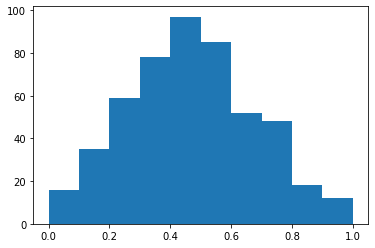

In [51]:
plt.hist(mapping(Pi(X[0], beta, 0)))

# Regulation optimization

In [127]:
def mapping(x):
    return (x - min(x))/(max(x) - min(x))
def loss(x, y, beta, mu):
    return sum((mapping(Pi(x, beta, mu)) - y)**2)

In [135]:
pre_los = 10**10
for lam in np.arange(0,11,1):
    try:
        [beta, mu] = main(lam)
        los = 0
        for i in range(len(data)):
            los += loss(data[i], out[i], beta, mu[i])
    #     print(lam)
    #     print(los, '\n', '===========')
        if los < pre_los:
            optimized_beta = beta
            optimized_mu = mu
            optimized_lam = lam
            # reset pre_los
            pre_los = los
    except:
        continue
    

<ipython-input-2-37d3a1e4b5c6>:40: RuntimeWarning: overflow encountered in square
  result = np.nan_to_num(- np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu)) ** 2)), nan=0)
<ipython-input-2-37d3a1e4b5c6>:56: RuntimeWarning: overflow encountered in multiply
  return sum(- np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
<ipython-input-2-37d3a1e4b5c6>:57: RuntimeWarning: overflow encountered in power
  / (1 + np.exp(x @ beta_0 + mu)) ** 3)), nan=0))
<ipython-input-2-37d3a1e4b5c6>:56: RuntimeWarning: invalid value encountered in true_divide
  return sum(- np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) * (np.exp(x @ beta_0 + mu) - 1) \
<ipython-input-2-37d3a1e4b5c6>:44: RuntimeWarning: overflow encountered in square
  result = np.nan_to_num(np.asarray((np.exp(x @ beta_0 + mu) / (1 + np.exp(x @ beta_0 + mu)) ** 2)), nan=0)
<ipython-input-2-37d3a1e4b5c6>:60: RuntimeWarning: overflow encountered in multiply
  return np.sum(- x * np.nan_

In [131]:
optimized_beta

array([[-0.20690591],
       [ 0.10998785],
       [-0.52825856],
       [-0.23689573],
       [ 0.34893608],
       [-0.19246987],
       [-0.054889  ],
       [ 0.11952627],
       [-0.00875196],
       [ 0.40329172]])

In [136]:
optimized_lam

3

In [133]:
optimized_mu

array([-0.85819599, -2.79508823])

In [137]:
output(data, optimized_beta, truth)

,Truth,Coef,Std.Err,z,P-value,[0.025,0.975]
X1,-1.50,-0.206906,0.105572,-1.959863,0.050012,-0.413822,0.000011
X2,0.10,0.109988,0.220020,0.499899,0.617146,-0.321244,0.541219
X3,-0.50,-0.528259,0.153659,-3.437870,0.000586,-0.829424,-0.227093
X4,-0.30,-0.236896,0.133238,-1.777990,0.075406,-0.498037,0.024246
X5,0.40,0.348936,0.129056,2.703748,0.006856,0.095990,0.601882
X6,-0.20,-0.192470,0.067308,-2.859521,0.004243,-0.324392,-0.060548
X7,-0.25,-0.054889,0.042885,-1.279915,0.200575,-0.138942,0.029164
X8,0.35,0.119526,0.229882,0.519946,0.603101,-0.331034,0.570087
X9,-0.10,-0.008752,0.163812,-0.053427,0.957392,-0.329818,0.312314
X10,0.50,0.403292,0.115029,3.506011,0.000455,0.177840,0.628744
